In [1]:
import json
import numpy as np

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [2]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

train_targs = (np.random.rand(40,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])
train_bttns = (np.random.rand(40,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])


In [3]:
np.shape(train_targs)

(40, 2)

In [4]:

#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

tb = 60

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, 99), 'T' : (tb, 100)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]



In [5]:
train_bttns

array([[-0.08263499, -0.2895323 ],
       [-0.74773489,  0.2615176 ],
       [-0.60439214, -0.62208201],
       [-0.28150632, -0.78596378],
       [ 0.96752439, -0.03798544],
       [ 0.22071687,  0.5891721 ],
       [-0.52480709, -0.6015578 ],
       [ 0.90689489, -0.22205966],
       [-0.20146502, -0.73216237],
       [ 0.09195017,  0.20357285],
       [-0.22599632,  0.82282119],
       [ 0.45640678,  0.84935443],
       [ 0.89149292,  0.77535069],
       [-0.53277017,  0.60522259],
       [ 0.76116301, -0.10298096],
       [-0.0075577 ,  0.1084018 ],
       [-0.8899516 , -0.17729831],
       [ 0.01937941,  0.94622142],
       [-0.14917631,  0.92165207],
       [-0.84233148, -0.4646715 ],
       [ 0.38930115, -0.66466426],
       [ 0.37871183, -0.30177209],
       [ 0.25042274,  0.56929883],
       [-0.47755535, -0.95142402],
       [-0.30021585,  0.44915008],
       [ 0.92068467, -0.61230777],
       [-0.87426376, -0.56282942],
       [ 0.05333505, -0.21102365],
       [ 0.74969927,

In [6]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 80, 2, 160
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 40.
sigma_targ = 0.#10**1.5
sigma_in = 20.#12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = 40

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb = LTTB (par)


In [7]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    print(k)
    lttb.y_targ_collection.append(train_exp[k][1])
    lttb.I_clock_collection.append( train_exp[k][0] )
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


<ipython-input-8-3ce73f3fdd1d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


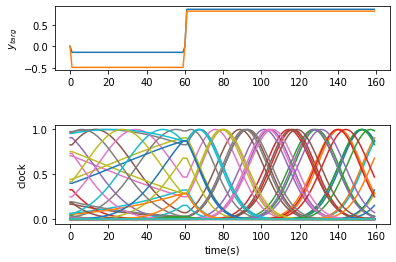

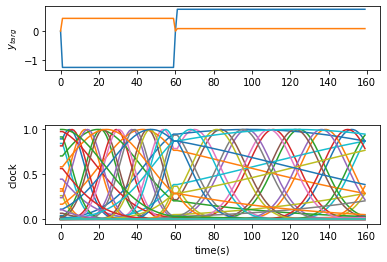

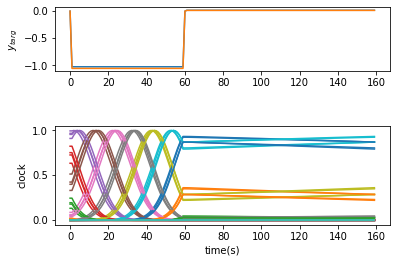

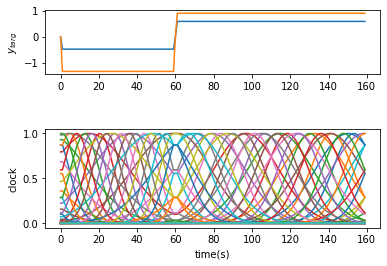

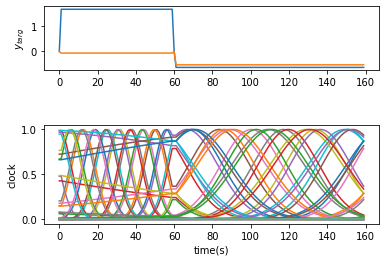

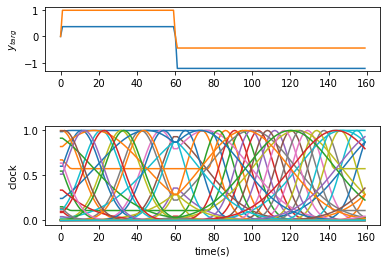

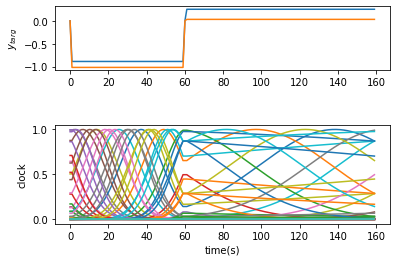

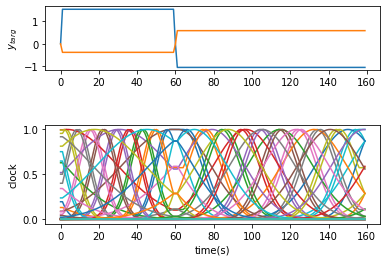

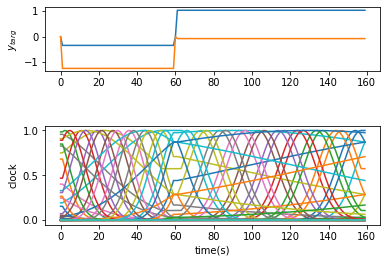

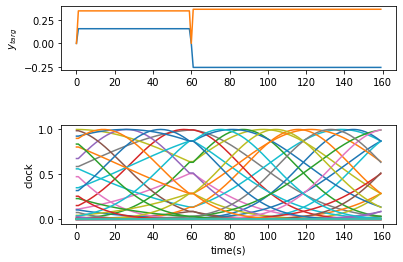

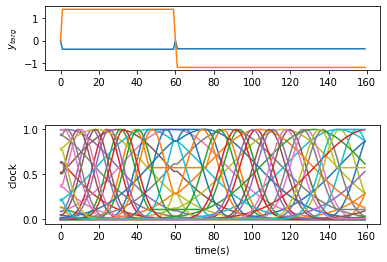

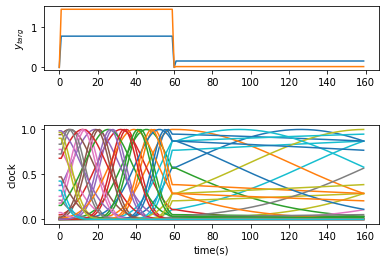

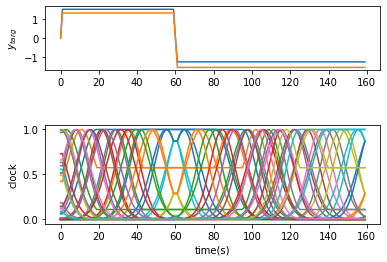

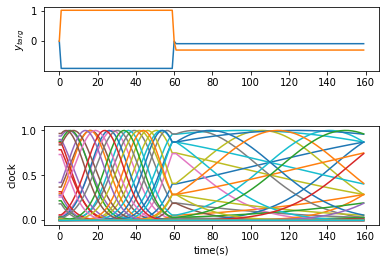

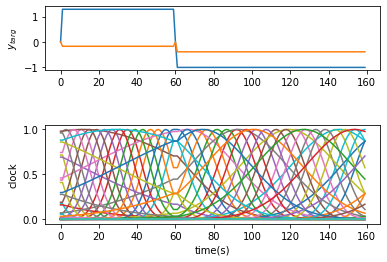

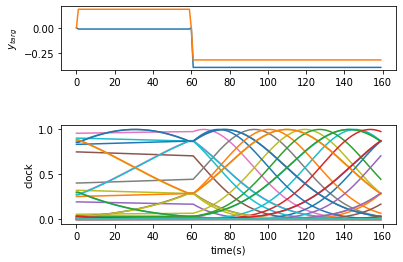

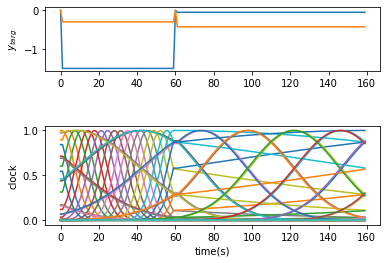

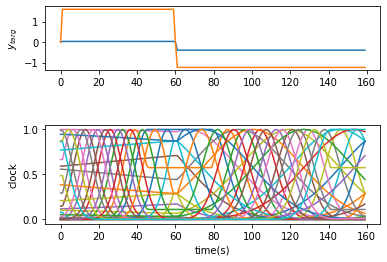

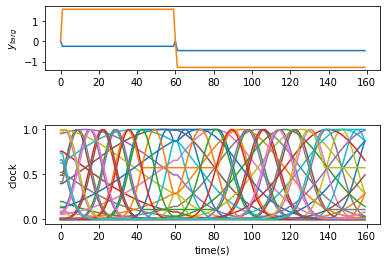

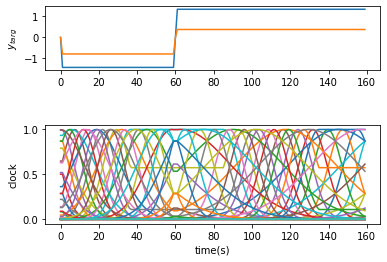

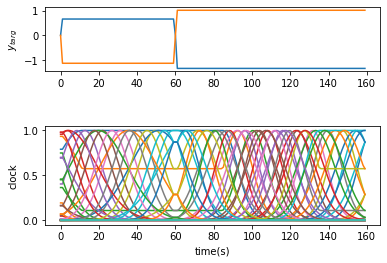

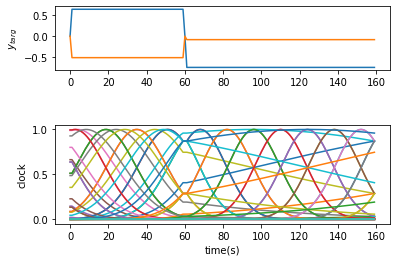

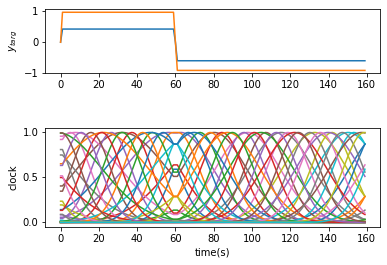

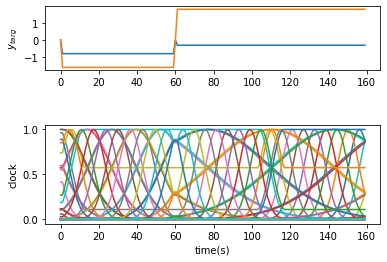

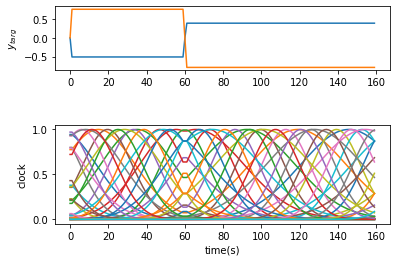

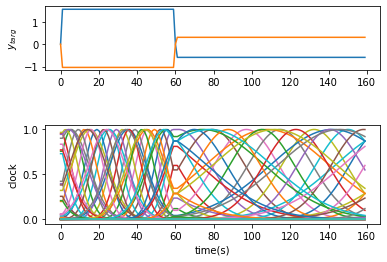

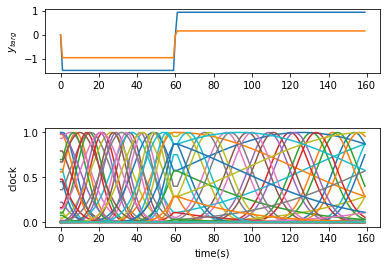

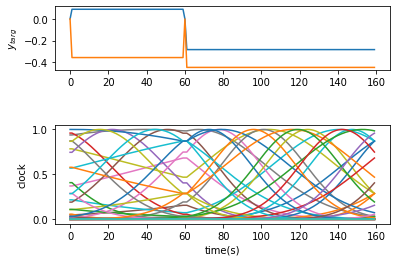

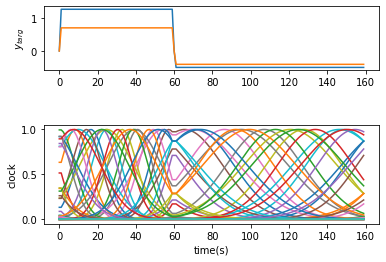

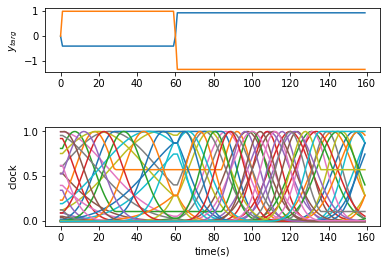

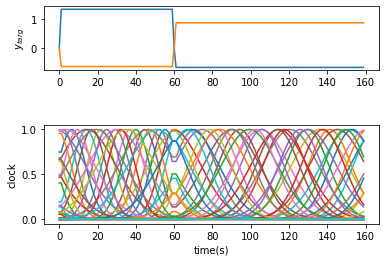

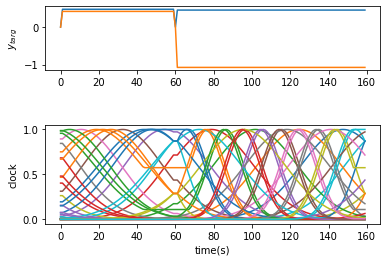

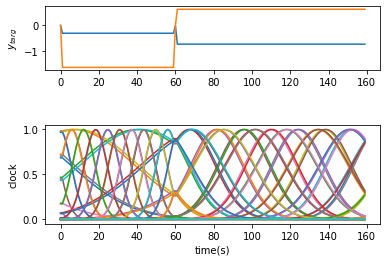

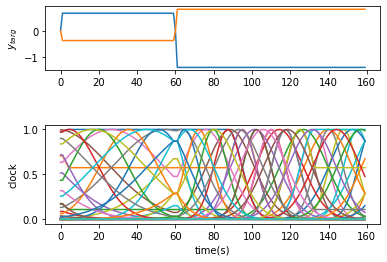

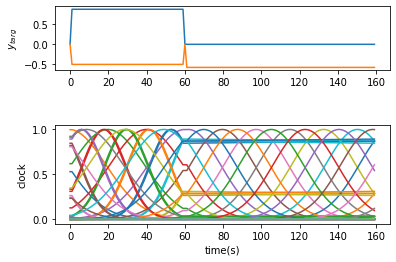

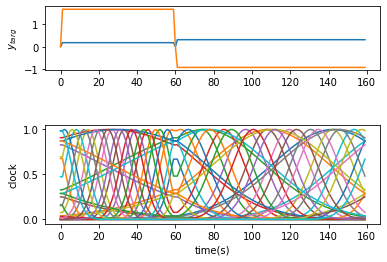

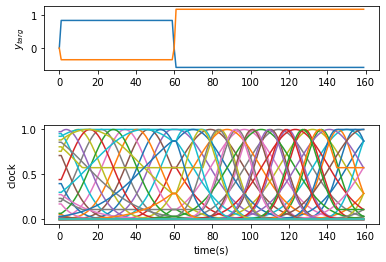

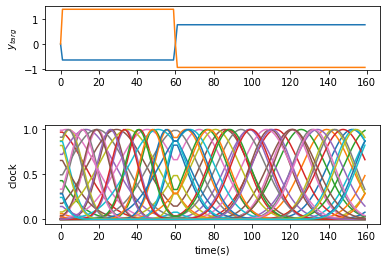

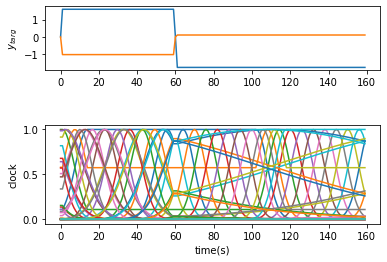

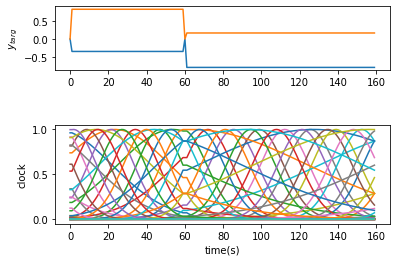

In [8]:
for k in range(n_contexts):

    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(212)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')

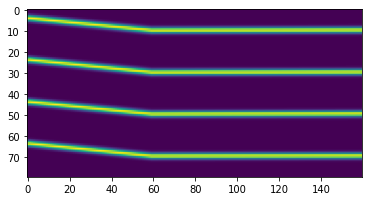

In [10]:
plt.imshow(np.array(lttb.I_clock_collection[2]))


In [11]:
## Training Rec
par['T'] = 160
lttb.T = 160
    
gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 50

eta = 0.
eta_out = 0.01
etaW = .0

for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_contexts):
        
        
        lttb.initialize(par)
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1

        #run simulation
        dH = 0

        for t in range(lttb.T-2):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)

            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
    ###### Test
    
    if iter%5==0:

        for cont_index in range(n_contexts):
            
            lttb.initialize(par)
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            lttb.I_clock = lttb.I_clock_collection[cont_index]
            
            
            lttb.cont = lttb.cont*0
            lttb.cont[0] = 1

            #run simulation

            for t in range(lttb.T-2):
                
                if t==tb:
                    lttb.cont = lttb.cont*0
                    lttb.cont[1] = 1
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]# 
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            print(mse_rec_train)
            

0.3799595548532702
0.5525376579082805
0.29548570308828953
0.760493676018317
0.5846143427398356
0.5145394864212373
0.32528969222667276
0.7536024850259486
0.7105833047340129
0.03445337427386119
0.7077173914990793
0.23132809860326134
1.6824024366340475
0.34693554468772053
0.5078586545713393
0.02792127906281836
0.32836775509243943
0.8518619620722845
0.870807309038636
1.1647087203856017
0.9892519567064543
0.20069117946717943
0.4235172545656691
1.5917639671752735
0.375074661333454
0.7077163385631002
0.9189241605036695
0.029202415466088004
0.412470768447332
0.9873369405456904
0.666093630994569
0.46383010826212234
0.6371492932896754
0.7074663837357207
0.26276224292016515
0.7282055646668607
0.522555853235603
0.8951966502168508
1.286386341813186
0.24451013833054894
0.3483167593338553
0.4666803507575698
0.25277545864218665
0.622883170731408
0.3740409030912207
0.3118947746854542
0.24067901897522478
0.5277010324256219
0.5644752314526146
0.0063239790294793855
0.5158098341093159
0.1558040040929533
1.

In [13]:
np.shape(Y)

(2,)

In [14]:
lttb.T

160

0.14953659667967764


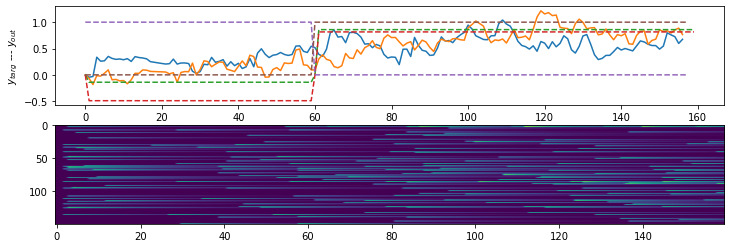

0.20562391789586767


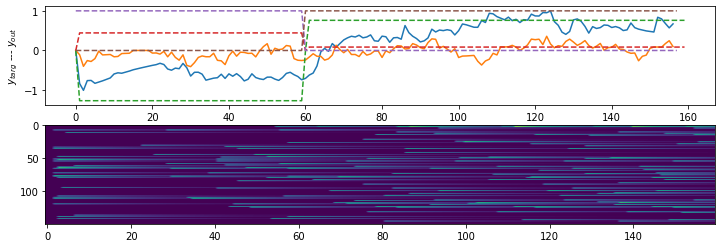

0.10906856258763278


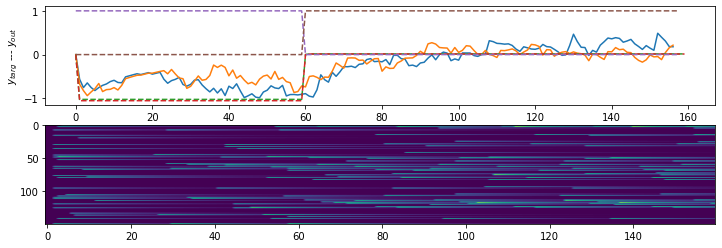

0.22255178253725444


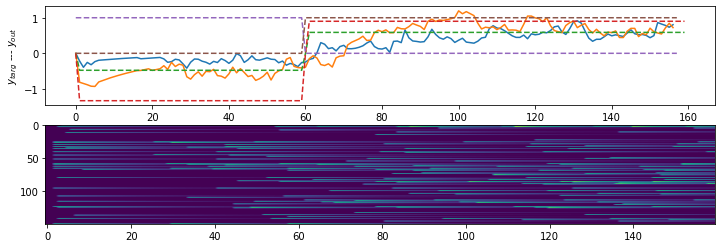

0.15450214878292257


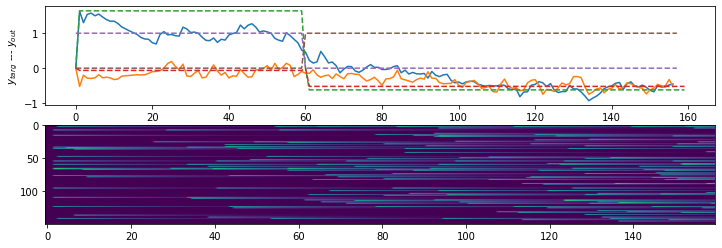

0.11341895264138664


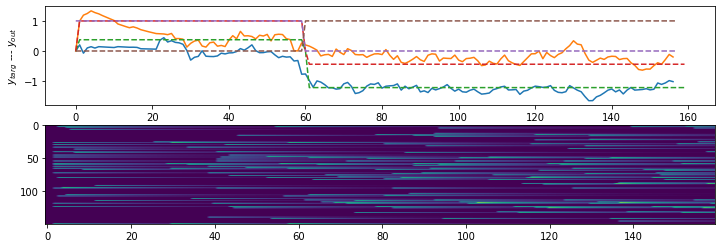

0.10558438416525329


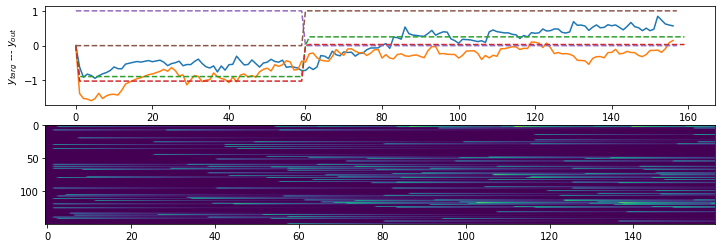

0.19112547205190852


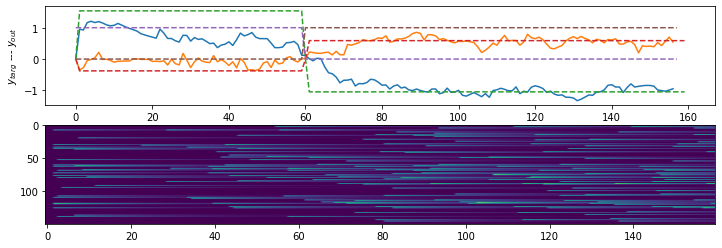

0.1954298069938055


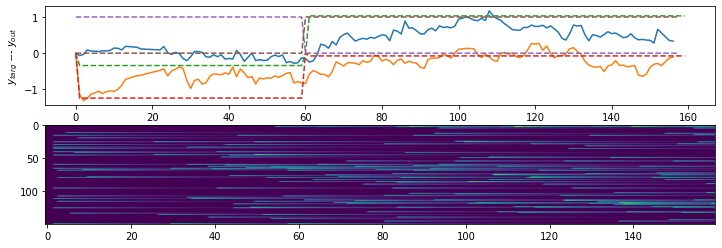

0.030498372632572674


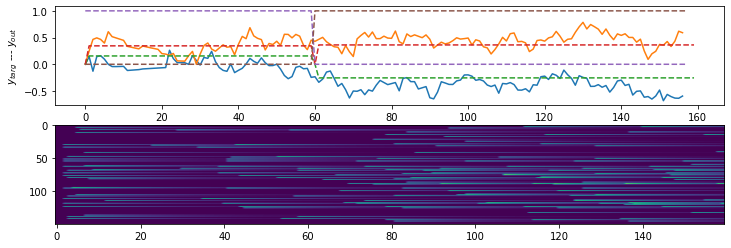

0.1684091451600999


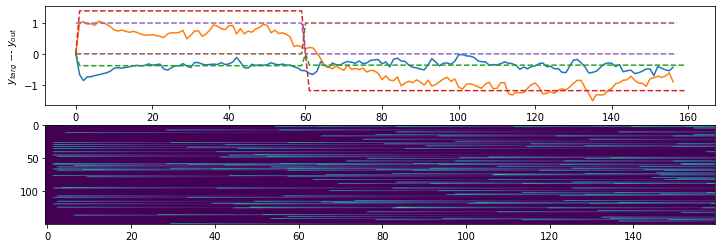

0.07648902869012243


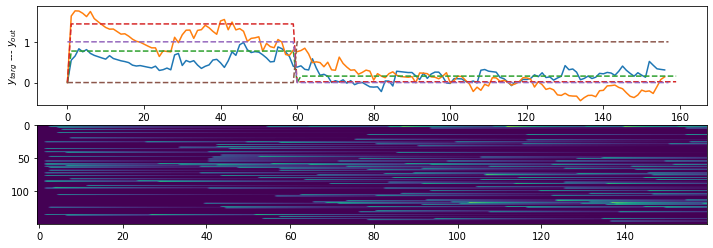

0.4828207273916795


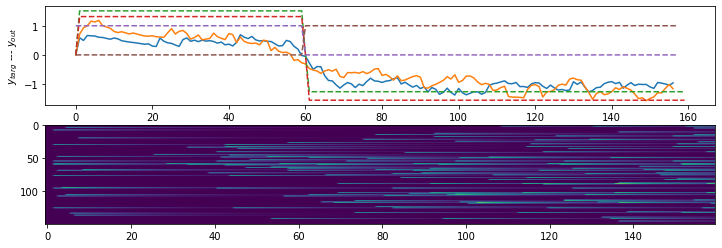

0.14820122000164174


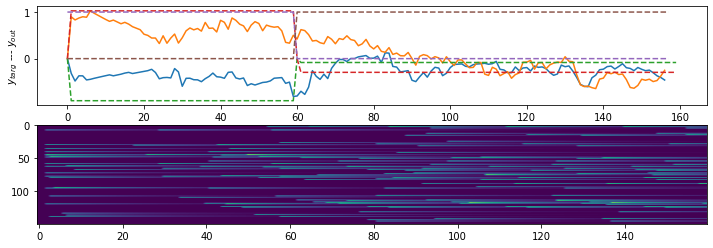

0.10638213128067045


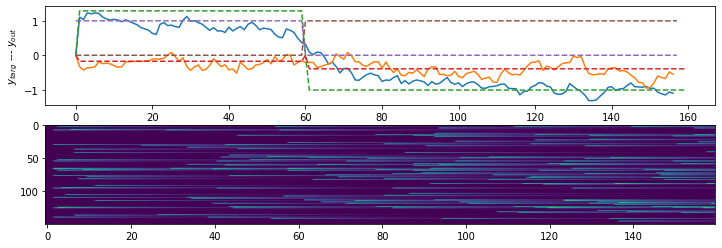

0.04048322877409915


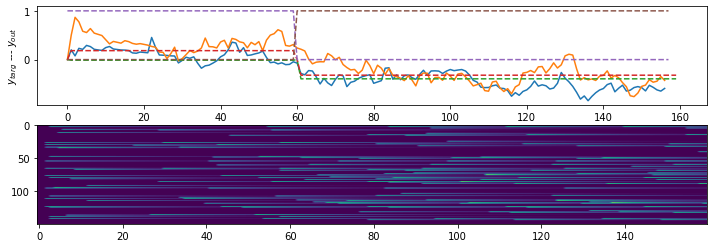

0.26864095729992515


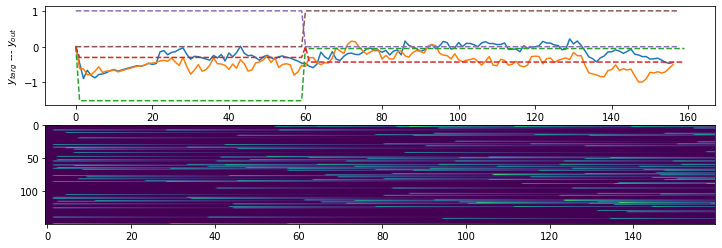

0.19621132126618077


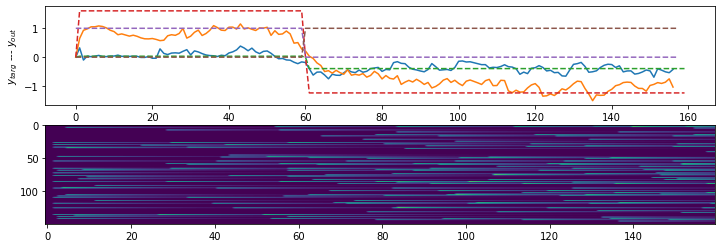

0.24536414276754412


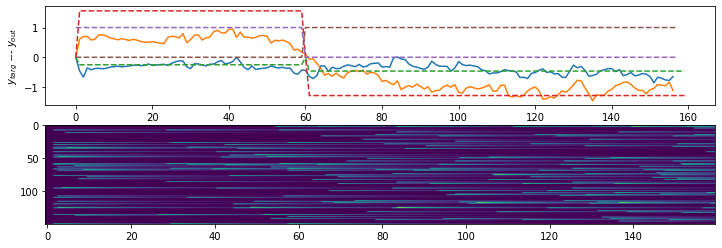

0.40133555958637196


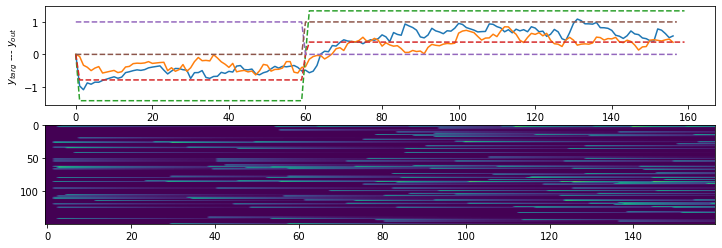

0.217971982901995


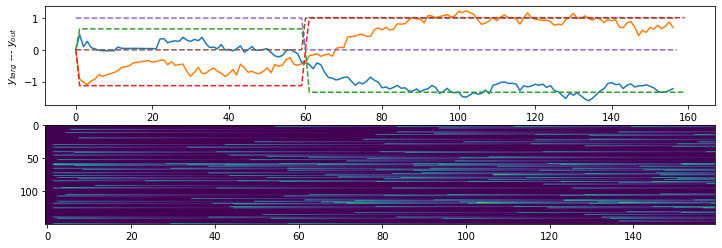

0.038905175062537316


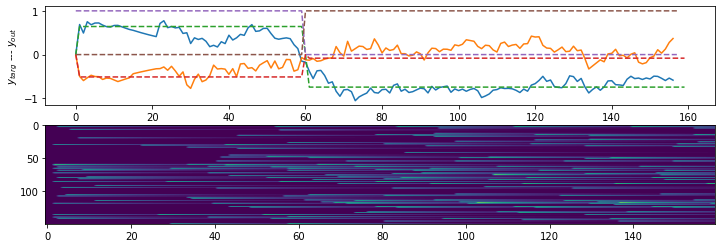

0.07003948184643871


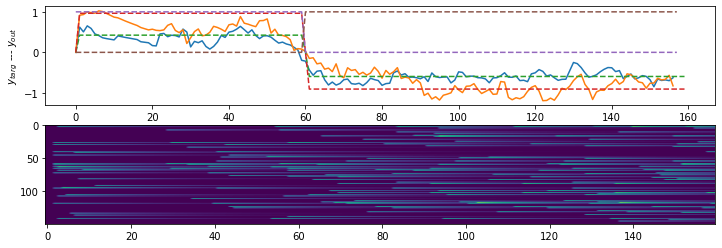

0.6960738225743197


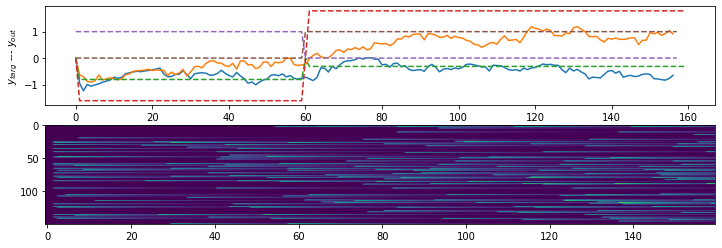

0.1148984418183498


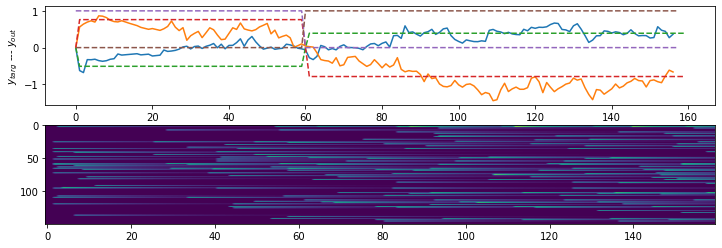

0.18075209990237395


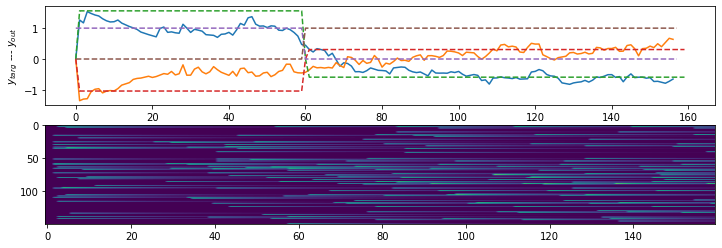

0.27661041996032026


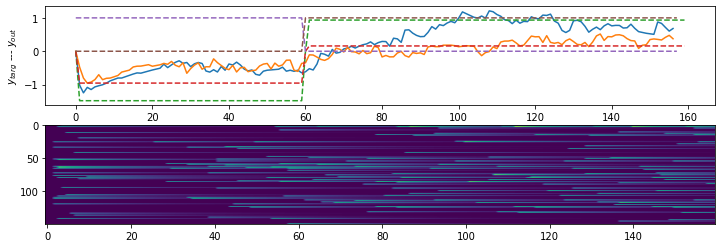

0.04734093723723822


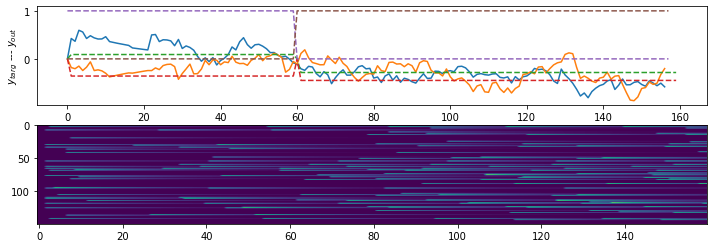

0.10360253612944456


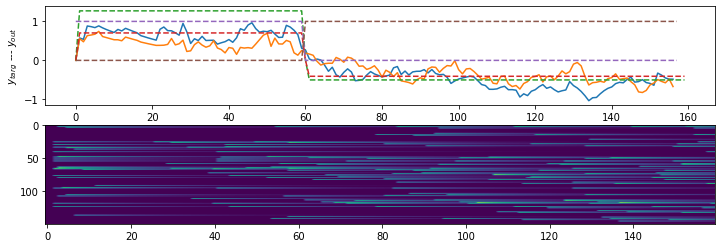

0.20322896351487646


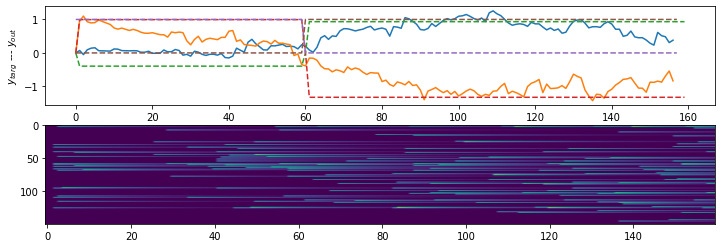

0.18137854642267076


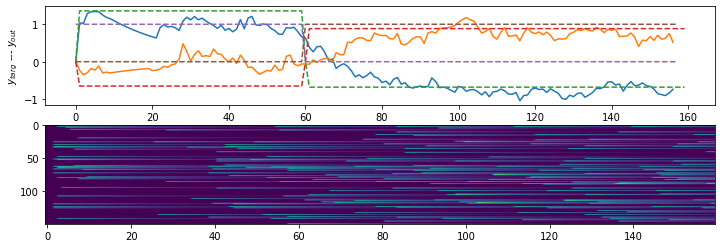

0.12210146027099018


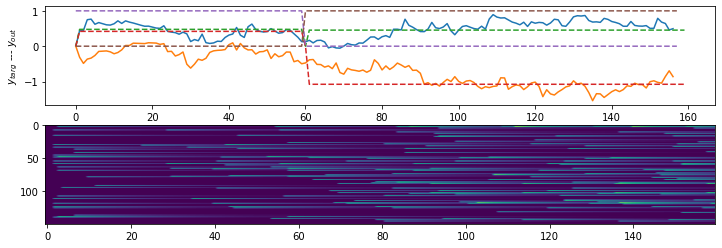

0.3010915863831132


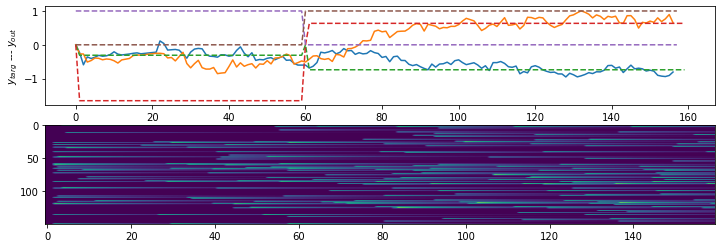

0.10068332851753949


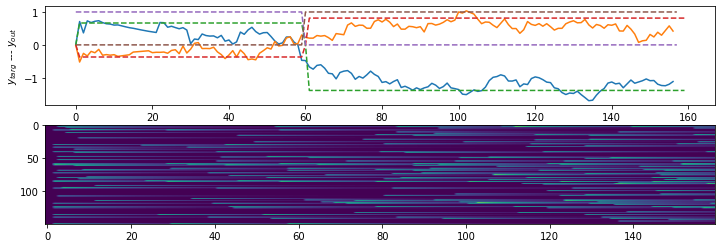

0.06956016127346445


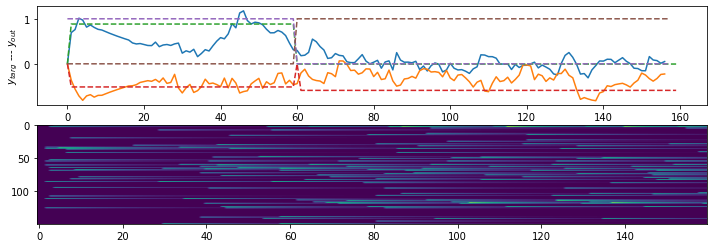

0.1904585095124412


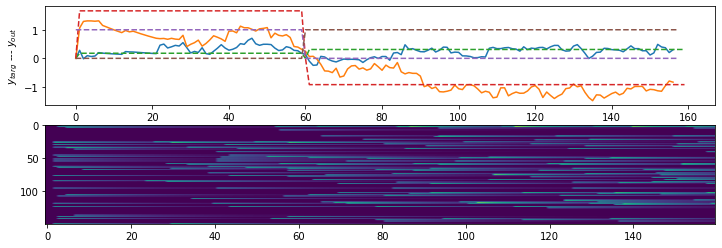

0.1567281150055246


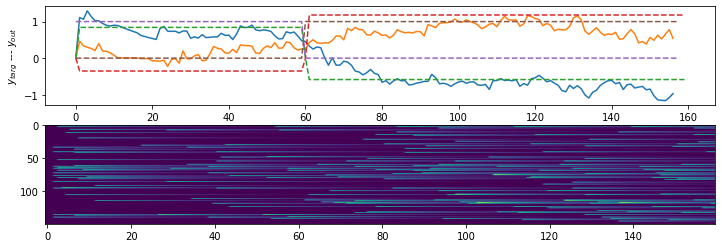

0.2088482715472289


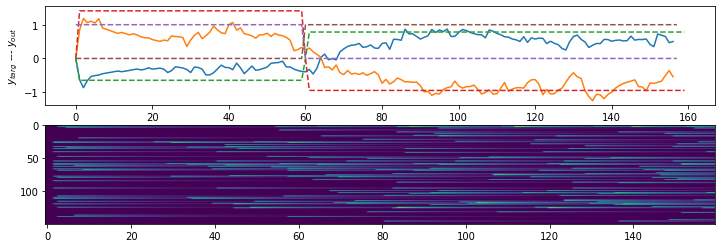

0.48799648059510575


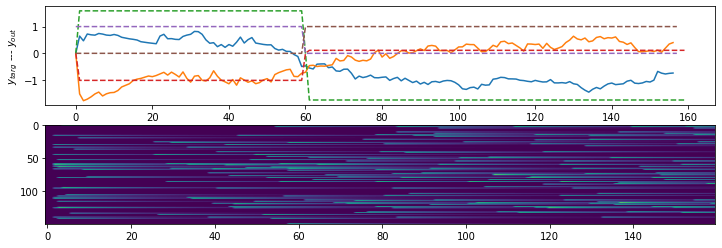

0.10597186407269955


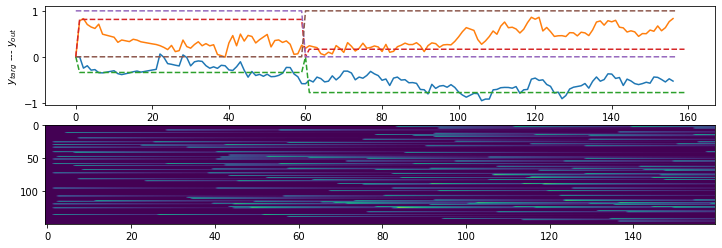

In [15]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.initialize(par)
    lttb.I_clock = lttb.I_clock_collection[cont_index]
    lttb.y_targ = lttb.y_targ_collection[cont_index]
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    #run simulation
    
    apicalFactor = 0
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    for t in range(lttb.T-2):
 
        if t==tb:
           
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
        context.append(lttb.cont)
        
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

R = 10.076616935346504


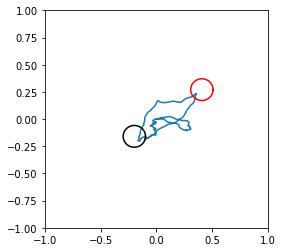

In [50]:
TIME_TEST = 1500
cont_index = 6

par['T'] = TIME_TEST
lttb.T = TIME_TEST
lttb.initialize(par)

lttb.y_targ = np.zeros((lttb.O,lttb.T))

targ_test = train_targs[cont_index]
btn_test = train_bttns[cont_index]

#theta = 30
#theta = theta/180*np.pi
targ_test = (np.random.rand(2)-.5)
btn_test = (np.random.rand(2)-.5)

trajectory = np.zeros((2,TIME_TEST-1))
trajectory[:,0] = init

env.reset (init = init, targ = targ_test, btn = btn_test)

agen = init

R = 0

ACTIONS = []
POSITION = []#np.zeros((2,TIME_TEST-2))
    
state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

#lttb.I_clock[:,0] *= 0

#state, r, done, agen = env.step ([0,0])
lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

lttb.cont = lttb.cont*0
lttb.cont[0] = 1

closed_loop = 1

context = []

btn_on=0

for t in range (TIME_TEST-2):
    
    if closed_loop:
        lttb.I_clock[:,lttb.t+1] = state
        if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:
            
            btn_on=1
            
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
        
    else:
        lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
        if t == tb:
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
            
    context.append(lttb.cont)
    
    lttb.step (apicalFactor = 0)
    action = lttb.Jout@lttb.B_filt[:,t]
    ACTIONS.append(action)
    
    state, r, done, agen = env.step (action)
    
    #POSITION[:,t] = agen
    POSITION.append( list(agen) )
    
    R = max (R, r)
    
    if np.sqrt( np.sum((agen - targ_test)**2) )  < 0.1 and btn_on==1:
        done = 1
    
    if done: break
        
print('R = ' + str(R))

plt.figure(figsize=(4,4))
#plt.plot(trajectory[0],trajectory[1],'o')
plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
plt.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
plt.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()



In [51]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 5.75901829533
R = 5.668703955584089
R = 0
R = 0
R = 6.063088588270659
R = 0
R = 0
R = 0
R = 0
R = 10.227185002635368
R = 0
R = 0
R = 0
R = 3.800070765286861
R = 0
R = 0
R = 10.237554962250684
R = 0
R = 0


Text(0.5, 0, 'Reward')

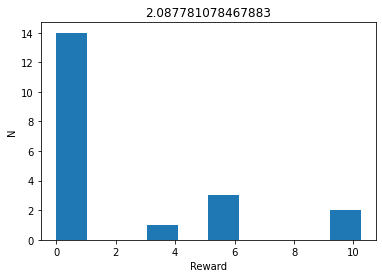

In [52]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")